In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv (r'../data/2022.csv')

In [3]:
data.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_FRTRES1,_VEGRES1,_FRUTSU1,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1
0,1.0,1.0,1192021,1,19,2021,1100.0,2021000001,2.021000e+09,1.0,...,1.0,1.0,100.0,214.0,1.0,1.0,1.0,1.0,0.0,0.0
1,1.0,1.0,1212021,1,21,2021,1100.0,2021000002,2.021000e+09,1.0,...,1.0,1.0,100.0,128.0,1.0,1.0,1.0,1.0,0.0,0.0
2,1.0,1.0,1212021,1,21,2021,1100.0,2021000003,2.021000e+09,1.0,...,1.0,1.0,100.0,71.0,1.0,2.0,1.0,1.0,0.0,0.0
3,1.0,1.0,1172021,1,17,2021,1100.0,2021000004,2.021000e+09,1.0,...,1.0,1.0,114.0,165.0,1.0,1.0,1.0,1.0,0.0,0.0
4,1.0,1.0,1152021,1,15,2021,1100.0,2021000005,2.021000e+09,1.0,...,1.0,1.0,100.0,258.0,1.0,1.0,1.0,1.0,0.0,0.0


In [4]:
data.shape

(438693, 303)

## Data Preprocessing

In [5]:
# we create a backup to the data
df = data.copy()

In [6]:
x = df.isna().sum()

In [7]:
x

_STATE      0
FMONTH      0
IDATE       0
IMONTH      0
IDAY        0
           ..
_VEGLT1A    0
_FRT16A     0
_VEG23A     0
_FRUITE1    0
_VEGETE1    0
Length: 303, dtype: int64

In [8]:
count = 0
for i in x:
    z = (i/438693)*100
    if z > 90:
        count+=1
print(count)

91


In [9]:
# As we see that 91 columns are having empty values greater than 50% so its better to drop them
df = df.loc[:, df.isna().sum() < 0.90*df.shape[0]]

In [10]:
df.shape

(438693, 212)

In [11]:
# CHCOCNCR(Other types of cancer), CHCSCNCR(skin cancer) - This field is for Chronic condition and has the following values:-
# 1 - Yes
# 2 - No
# 7 - Don't Know
# 9 - Refused
# For our analysis purpose we only need rows where CHCOCNCR or CHCSCNCR is 1 or 2

df = df.loc[(df['CHCSCNCR'].isin([1, 2]) | df['CHCOCNCR'].isin([1, 2]))]


In [12]:
df.shape

(438291, 212)

In [13]:
# store the count of label for cancer disease
skin_cancer_count = np.where(df['CHCSCNCR']==1, 1, 0) #for skin cancer
other_cancer_count = np.where(df['CHCOCNCR']==1, 1, 0) # for other cancer
skin_other_count = np.where((df['CHCSCNCR']==1) | (df['CHCOCNCR']==1), 1, 0)


In [14]:
# drop the cancer label coulmn 
df = df.drop(['CHCSCNCR'], axis=1)
df = df.drop(['CHCOCNCR'], axis=1)

In [15]:
df.shape

(438291, 210)

### There are some columns which are not related to health as per our observation from the code book hence its better to remove them

In [16]:
# removing columns FMONTH, DISPCODE, SEQNO, PVTRESD1, HHADULT
df = df.drop(columns = ['FMONTH','DISPCODE','SEQNO','PVTRESD1','HHADULT', 'STATERE1', 'CELPHON1'], axis=1)
# removing date columns IMONTH, IDAY, IDATE, and IYEAR as they are the columns of interview date
df = df.drop(columns = ['IMONTH', 'IDAY', 'IDATE', 'IYEAR'], axis=1)

## Heatmaps are a good way to find out the coorelation between columns. This way we can remove the highly corelated columns 

In [17]:
# Replacing the NaN or Null values with the mode of each columns
df2 = df.fillna(df.median())
# creating a corelation matrix
corr_mat = df2.corr().abs()

In [18]:
corr_mat

,_STATE,_PSU,CTELENM1,LADULT1,NUMADULT,LANDSEX,NUMMEN,NUMWOMEN,RESPSLCT,SAFETIME,...,_FRTRES1,_VEGRES1,_FRUTSU1,_VEGESU1,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1
_STATE,1.000000,0.046555,0.001078,0.052158,0.002084,0.007917,0.010886,0.009686,0.009649,NaN,...,0.004736,0.005854,0.001418,0.004332,0.004981,0.004191,0.002045,0.002270,0.005208,0.006339
_PSU,0.046555,1.000000,0.001632,0.033594,0.101536,0.106525,0.041926,0.065259,0.151604,NaN,...,0.028972,0.029333,0.041220,0.051861,0.030175,0.029469,0.045656,0.055641,0.045385,0.051695
CTELENM1,0.001078,0.001632,1.000000,0.000088,0.002128,0.005283,0.000163,0.000243,0.000558,NaN,...,0.000774,0.000850,0.000196,0.000119,0.000661,0.000989,0.000152,0.000183,0.000777,0.000855
LADULT1,0.052158,0.033594,0.000088,1.000000,0.016770,0.002614,0.006788,0.019986,0.000899,NaN,...,0.000685,0.000049,0.001684,0.003174,0.000573,0.000196,0.002927,0.003529,0.000561,0.001633
NUMADULT,0.002084,0.101536,0.002128,0.016770,1.000000,0.401737,0.436977,0.451937,0.181858,NaN,...,0.000459,0.011948,0.006895,0.004434,0.003819,0.014856,0.002909,0.000814,0.001611,0.010487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_VEGLT1A,0.004191,0.029469,0.000989,0.000196,0.014856,0.014157,0.000402,0.001771,0.006747,NaN,...,0.728413,0.991044,0.028169,0.049867,0.720994,1.000000,0.014025,0.039712,0.667010,0.882422
_FRT16A,0.002045,0.045656,0.000152,0.002927,0.002909,0.001722,0.001059,0.001003,0.000372,NaN,...,0.025780,0.011880,0.830494,0.368483,0.036330,0.014025,1.000000,0.398050,0.384194,0.168399
_VEG23A,0.002270,0.055641,0.000183,0.003529,0.000814,0.001938,0.000060,0.004032,0.000559,NaN,...,0.021542,0.034122,0.375026,0.827891,0.025886,0.039712,0.398050,1.000000,0.142510,0.419175
_FRUITE1,0.005208,0.045385,0.000777,0.000561,0.001611,0.001593,0.002999,0.001001,0.003337,NaN,...,0.913041,0.672463,0.303213,0.127255,0.892942,0.667010,0.384194,0.142510,1.000000,0.675043


In [19]:
high_corrcol = []
for i in range(1,corr_mat.shape[0]-1):
    for j in range(0,i):
        if corr_mat.iloc[i][j] > 0.85:
            high_corrcol.append(corr_mat.columns[j])
high_corrcol

['ACETOUCH',
 'ACETTHEM',
 '_STATE',
 '_STRWT',
 '_CRACE1',
 '_STRWT',
 '_WT2RAKE',
 'EXERANY2',
 'LMTJOIN3',
 '_PRACE1',
 '_RACE',
 '_RACEG21',
 '_IMPRACE',
 '_RACE',
 'SEXVAR',
 '_HCVU652',
 '_AGEG5YR',
 '_AGEG5YR',
 '_AGE80',
 'HTIN4',
 'WTKG3',
 'EDUCA',
 '_RFSMOK3',
 'DRNKANY5',
 'DRNKANY5',
 'DROCDY3_',
 'DRNKANY5',
 'DROCDY3_',
 '_RFBING5',
 'DRNKANY5',
 'DROCDY3_',
 '_RFBING5',
 '_DRNKWK1',
 'HIVTST7',
 '_MISFRT1',
 '_MISFRT1',
 '_MISVEG1',
 'FRUTDA2_',
 'VEGEDA2_',
 '_MISFRT1',
 '_FRTRES1',
 '_MISVEG1',
 '_VEGRES1',
 '_MISFRT1',
 '_FRTRES1',
 '_FRTLT1A']

In [20]:
df2 = df2.drop(high_corrcol,axis = 1)

In [21]:
df2.shape

(438291, 167)

In [22]:
# Now we are inserting the labels columns back to the dataframe
df2.insert(len(df2.columns), 'Cancerlabels', skin_other_count)

In [23]:
df2.shape

(438291, 168)

In [24]:
final_data = df2.copy()

# Data Visulization

## Relationship between health condition and cancer
The data provided has the chronic health condition criteria which will help us to know how chronic health condition is related to cancer
Field name for chronic health condition - HAVARTH5


In [25]:
data_visual1 = final_data.copy()

In [26]:
# Convert values

data_visual1['HAVARTH5'].replace(2, 0, inplace=True)
data_visual1['HAVARTH5'].replace(7, np.nan, inplace=True)
data_visual1['HAVARTH5'].replace(9, np.nan, inplace=True)

In [27]:
plt.figure(figsize=(15,20))
data_visual = data_visual1.groupby(['HAVARTH5','Cancerlabels']).size()

<Figure size 1500x2000 with 0 Axes>

In [28]:
plot_data = data_visual.unstack()
data_transpose = plot_data.transpose()
data_percent_split = data_transpose.div(data_transpose.sum())
data_to_plot_percent2 = data_percent_split.transpose()

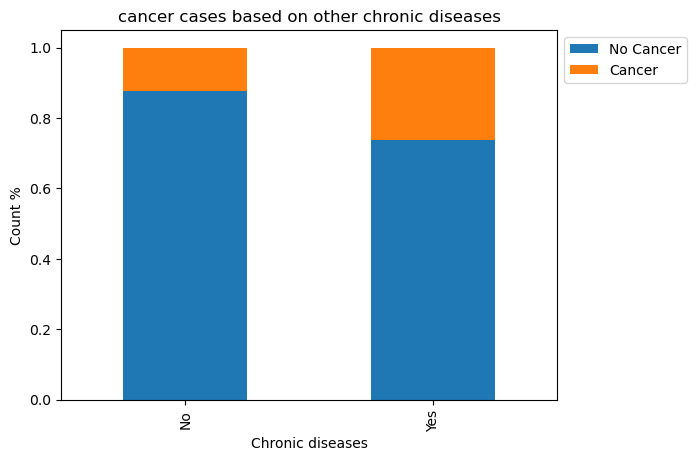

In [29]:
data_to_plot_percent2.plot(kind='bar',stacked=True).legend(["No Cancer", "Cancer"], loc='upper left', bbox_to_anchor=(1,1), ncol=1)
positions = (0, 1)
labels = ("No", "Yes")
plt.xticks(positions, labels)
plt.xlabel('Chronic diseases')
plt.ylabel('Count %')
plt.title("cancer cases based on other chronic diseases")

plt.show()

# Classification of having cancer

In [30]:
final_data.head()

,_PSU,CTELENM1,LADULT1,NUMADULT,LANDSEX,NUMMEN,NUMWOMEN,RESPSLCT,SAFETIME,CTELNUM1,...,FRNCHDA_,POTADA1_,_FRUTSU1,_VEGESU1,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1,Cancerlabels
0,2.021000e+09,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,...,43.0,14.0,100.0,214.0,1.0,1.0,1.0,0.0,0.0,0
1,2.021000e+09,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,...,0.0,14.0,100.0,128.0,1.0,1.0,1.0,0.0,0.0,0
2,2.021000e+09,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,...,14.0,14.0,100.0,71.0,2.0,1.0,1.0,0.0,0.0,0
3,2.021000e+09,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,...,57.0,27.0,114.0,165.0,1.0,1.0,1.0,0.0,0.0,0
4,2.021000e+09,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,...,29.0,29.0,100.0,258.0,1.0,1.0,1.0,0.0,0.0,0


In [31]:
#Seperating the labels from the dataset
cancer_label = final_data['Cancerlabels']

#drop the Cancerlabel
final_data.drop(['Cancerlabels'], axis=1, inplace=True)

In [32]:
has_cancer = 0
no_cancer = 0
for i in cancer_label:
    if i == 0:
        has_cancer+=1
    else:
        no_cancer+=1

# Actual count of cancer labels below
print(has_cancer," ",no_cancer)

364506   73785


## It is better to scale the features before proceeding to classification

In [33]:
# Using Standard scaler to scale the data
scaler = StandardScaler()
final_normalized = scaler.fit_transform(final_data)

## Test_Train Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(final_normalized, cancer_label, shuffle=True, test_size=0.3, random_state=42)

## Random Forest for Classification

In [35]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [36]:
model = RandomForestClassifier()
params = {'max_depth':[10, 15], 'n_estimators':[100, 150]}

gsc = GridSearchCV(model, params, cv=5,verbose=2)
gsc.fit(X_train,y_train.ravel())
gsc_best = gsc.best_estimator_
y_pred=gsc_best.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................max_depth=10, n_estimators=100; total time=  28.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=  27.8s
[CV] END .....................max_depth=10, n_estimators=100; total time=  26.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=  27.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=  28.1s
[CV] END .....................max_depth=10, n_estimators=150; total time=  40.7s
[CV] END .....................max_depth=10, n_estimators=150; total time=  41.1s
[CV] END .....................max_depth=10, n_estimators=150; total time=  42.3s
[CV] END .....................max_depth=10, n_estimators=150; total time=  43.5s
[CV] END .....................max_depth=10, n_estimators=150; total time=  41.3s
[CV] END .....................max_depth=15, n_estimators=100; total time=  37.6s
[CV] END .....................max_depth=15, n_est

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91    109268
           1       0.61      0.01      0.02     22220

    accuracy                           0.83    131488
   macro avg       0.72      0.50      0.46    131488
weighted avg       0.79      0.83      0.76    131488



In [38]:
with open('Final_Project_rf.dat', 'w') as fw:
    for m in y_pred:
        print(m, file=fw)

# Logistic Regression

In [39]:
parameters = {'max_iter':[100, 150, 200]}

In [40]:
model = LogisticRegression(class_weight="balanced")
clf = GridSearchCV(model, parameters, scoring='recall')
clf.fit(X_train, y_train)

/Users/shreyas/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/shreyas/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'max_iter': [100, 150, 200]}, scoring='recall')

In [41]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77    109268
           1       0.31      0.78      0.45     22220

    accuracy                           0.67    131488
   macro avg       0.62      0.72      0.61    131488
weighted avg       0.83      0.67      0.71    131488



In [42]:
with open('Final_Project_lr.dat', 'w') as fw:
    for m in y_pred:
        print(m, file=fw)

# Decision Tree

In [43]:
parameters = {'splitter':['best', 'random'], 'max_depth':[5, 10, 15, 20, 25], 'criterion':['gini', 'entropy']}

In [45]:
from sklearn import tree

In [46]:
model = tree.DecisionTreeClassifier(class_weight="balanced")
clf = GridSearchCV(model, parameters, scoring='recall')
clf.fit(X_train, y_train)

KeyboardInterrupt: 